# Google Stock Price LSTM
### By Mojisoluwa Awe

In this notebook I will be exmaining stock price data for Google from 2004 to 2024, leveraging a dataset I found on Kaggle. First, I will go through some Exploratory Data Analysis to gain a better understanding of the data before building and examining a LSTM model to predict the Closing Price of the stock.

If you have any suggestions or comments please feel free to reach out!

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm.notebook import tqdm

In [44]:
df = pd.read_csv('GOOGL_2004-08-01_2024-12-18.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,2.502503,2.604104,2.401401,2.511011,2.501941,893181924
1,2004-08-20,2.527778,2.729730,2.515015,2.710460,2.700670,456686856
2,2004-08-23,2.771522,2.839840,2.728979,2.737738,2.727849,365122512
3,2004-08-24,2.783784,2.792793,2.591842,2.624374,2.614895,304946748
4,2004-08-25,2.626627,2.702703,2.599600,2.652653,2.643072,183772044


In [45]:
df['Date'] = pd.to_datetime(df.Date)

In [46]:
df['Daily_Return'] = df['Close'].pct_change() * 100

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5118 entries, 0 to 5117
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          5118 non-null   datetime64[ns]
 1   Open          5118 non-null   float64       
 2   High          5118 non-null   float64       
 3   Low           5118 non-null   float64       
 4   Close         5118 non-null   float64       
 5   Adj Close     5118 non-null   float64       
 6   Volume        5118 non-null   int64         
 7   Daily_Return  5117 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 320.0 KB


In [9]:
#df.isnull().sum()

## EDA
In this section we will be examining and visualizing the dataset. From reading the description from Kaggle I know this is a dataset containing a limited amount of data including date, opening price, highest price of the day, lowest price of the day, closing price, closing price after adjustments, and the number of shares traded that day (volume).

In [48]:
print('Earliest Date: ', df['Date'].min())
print('Latest Date: ' , df['Date'].max())

Earliest Date:  2004-08-19 00:00:00
Latest Date:  2024-12-17 00:00:00


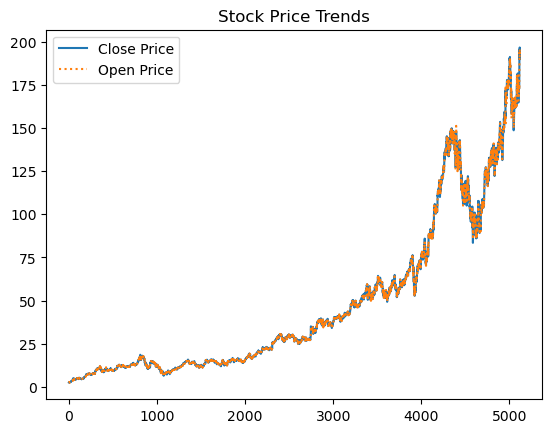

In [50]:
plt.plot(df.index, df['Close'], label='Close Price')
plt.plot(df.index, df['Open'], label='Open Price', linestyle = 'dotted')
plt.title('Stock Price Trends')
plt.legend()

Text(0.5, 1.0, 'Distribution of Daily Returns (%)')

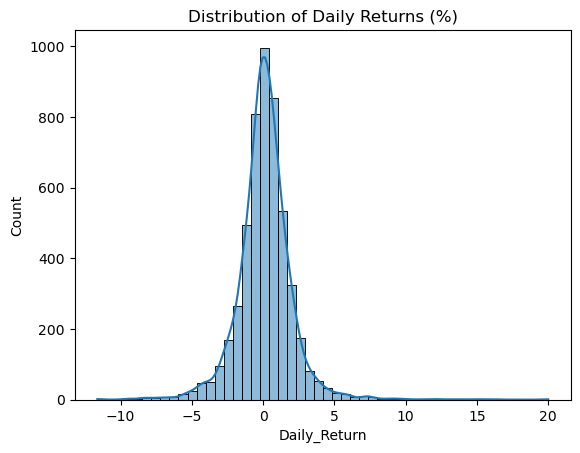

In [51]:
sns.histplot(df['Daily_Return'], bins=50, kde=True)
plt.title('Distribution of Daily Returns (%)')

Text(0.5, 1.0, 'Distribution of Closing Prices')

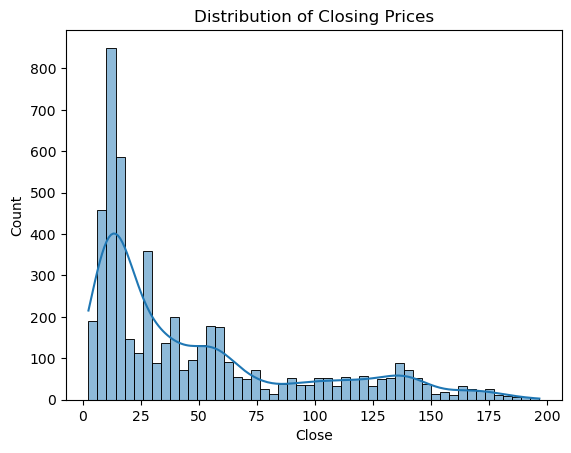

In [52]:
sns.histplot(df['Close'], bins=50, kde=True)
plt.title('Distribution of Closing Prices')

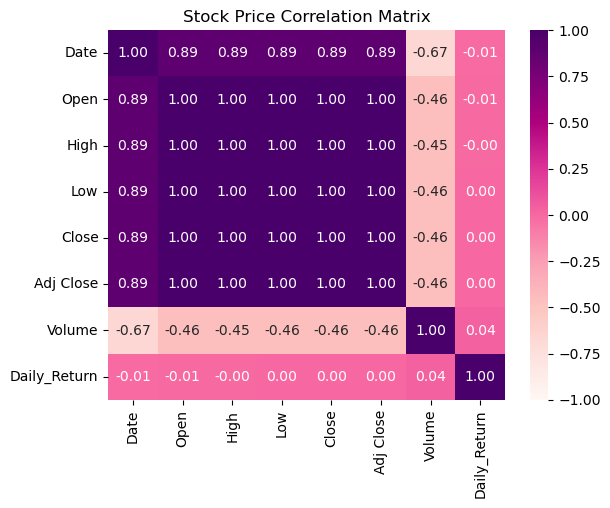

In [53]:
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot = True, cmap = 'RdPu', fmt = '.2f', vmin = -1, vmax = 1)
plt.title('Stock Price Correlation Matrix')
plt.show()

From this correlation matrix we can see that there is a strong correlation between between the closing price and all of the metrics (Date, Open, High, Low), aside from Volume. This is most likely due to the fact that the price of a stock may fluctuate for various reasons that don't directly affect the volume. For example, a stock price may rise due to a new innovation or technology release, but that doesn't necessarily mean there will be sn impact to trading volume.

In [55]:
df = df.sort_values(by = 'Date')
#df.head()

In [56]:
scaler = MinMaxScaler()

In [58]:
features = df[['Open', 'High', 'Low', 'Daily_Return', 'Volume']].values
target = df['Close'].values.reshape(-1, 1)

features = scaler.fit_transform(features)
target = scaler.fit_transform(target)

I chose to normalize the data due to the difference in ranges between certain values, such as the stock price, daily return, and volume. The stock prices range from 0 to 200 dollars, the daily returns are a percentage between 0 and 100, and the volume is the millions.

## Sequences

I'm creating sliding window sequences to make this time series prediction. I'm setting the train window to 7, this means that in order to make a prediction, the model will be using 7 time steps (7 days of data with the Open, High, Low, Daily Change, Year, and Volume) to predict the next value (Closing price of the 8th day).

In [59]:
train_window = 7

def create_sequences(features, target, train_window):
    sequences = []
    
    for i in range(len(features) - train_window):
        input_seq = features[i : i + train_window]
        
        label = target[i + train_window]
        
        sequences.append((input_seq, label))
    return sequences
    
data = create_sequences(features, target, train_window)

## Training & Testing Split

In [60]:
test_size = 0.3
split_index = int(len(data) * (1 - test_size))

train = data[:split_index]
test = data[split_index:]

In [61]:
train_sequences = torch.tensor([seq for seq, _ in train], dtype = torch.float32)
train_labels = torch.tensor([label for _, label in train], dtype = torch.float32)

batch_size = 32
train_dataset = TensorDataset(train_sequences, train_labels)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

/var/folders/j6/dnffdgcd71z4km6khzwmss5w0000gn/T/ipykernel_65995/507284264.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  train_sequences = torch.tensor([seq for seq, _ in train], dtype = torch.float32)


## Building the LSTM

In [41]:
class LSTM(nn.Module):
    def __init__(self, input_size = 4, hidden_layer_size = 100, output_size = 1, num_layers = 1):
        super(LSTM, self).__init__()
        
        self.hidden_layer_size = hidden_layer_size
        
        self.num_layers = num_layers
        # LSTM Layer
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first = True)
        # fully connected layer
        self.linear = nn.Linear(hidden_layer_size, output_size)
    
    def forward(self, input_seq):
        batch_size = input_seq.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_layer_size).to(input_seq.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_layer_size).to(input_seq.device)
        
        lstm_out, (hidden, cell) = self.lstm(input_seq, (h0, c0))
        
        predictions = self.linear(lstm_out[:, -1, :])
        return predictions

In [57]:
model = LSTM(input_size = 6, hidden_layer_size = 128, output_size = 1, num_layers = 2)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

## Model Training

In [58]:
epochs = 6

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    
    for seq, labels in tqdm(train_loader):
        seq = seq.view(seq.size(0), seq.size(1), -1)
        labels = labels.view(-1, 1)
        
        optimizer.zero_grad()
        
        y_pred = model(seq)
        
        single_loss = loss_function(y_pred, labels)
        
        single_loss.backward()
        
        optimizer.step()
        
        epoch_loss += single_loss.item()
    
    average_loss = epoch_loss / len(train_loader)
    print(f'epoch {epoch+1}/{epochs}, Loss: {average_loss:.10f}')

  0%|          | 0/112 [00:00<?, ?it/s]

epoch 1/6, Loss: 0.0015707704


  0%|          | 0/112 [00:00<?, ?it/s]

epoch 2/6, Loss: 0.0000655293


  0%|          | 0/112 [00:00<?, ?it/s]

epoch 3/6, Loss: 0.0000448965


  0%|          | 0/112 [00:00<?, ?it/s]

epoch 4/6, Loss: 0.0000223844


  0%|          | 0/112 [00:00<?, ?it/s]

epoch 5/6, Loss: 0.0000179454


  0%|          | 0/112 [00:00<?, ?it/s]

epoch 6/6, Loss: 0.0000158325


In [61]:
model.eval()

test_sequences = torch.tensor([seq for seq, _ in test], dtype = torch.float32)
test_labels = torch.tensor([label for _, label in test], dtype = torch.float32)

with torch.no_grad():
    predictions = model(test_sequences).view(-1)

In [65]:
print('MAE: ', mean_absolute_error(test_labels, predictions))
print('RMSE: ', np.sqrt(mean_squared_error(test_labels, predictions)))

MAE:  0.032330118
RMSE:  0.04371791


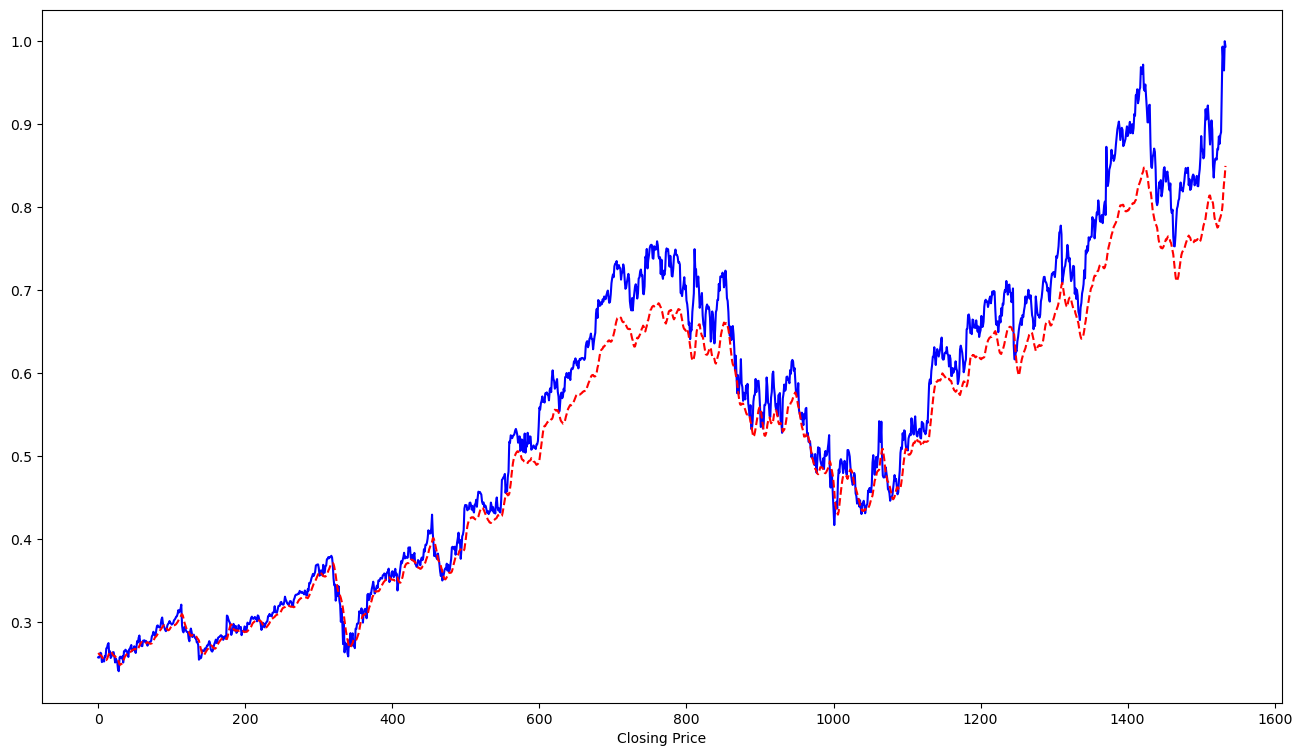

In [72]:
plt.figure(figsize = (16, 9))
plt.plot(test_labels, color = 'blue')
plt.plot(predictions, color = 'red', linestyle = 'dashed')
plt.xlabel('Closing Price')
plt.show()

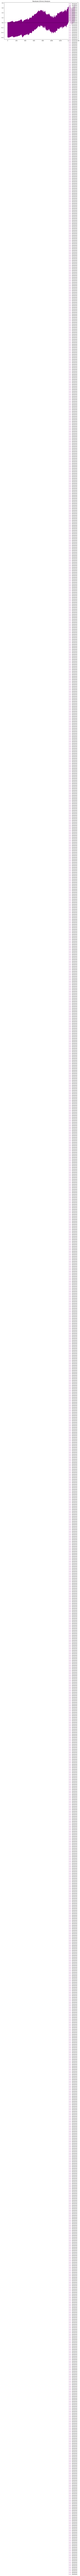

In [75]:
# Residuals
residuals = test_labels - predictions

plt.figure(figsize=(12, 6))
plt.plot(residuals, label="Residuals", color="purple")
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.title("Residuals (Errors) Analysis")
plt.legend()
plt.show()
